Clustering
===
*Bothound project*

# Initialization

In [1]:
# import
import numpy as np
import sklearn
from sklearn.cluster import KMeans
from scipy.spatial.distance import cdist,pdist
from scipy.signal import argrelextrema
%matplotlib inline
from pylab import *
from numpy import *
from mpl_toolkits.mplot3d import axes3d
import matplotlib.pyplot as plt

In [4]:
# %load "../src/bothound_tools.py"
from bothound_tools import BothoundTools

ImportError: No module named bothound_tools

In [4]:


features = [
            "request_interval", #1
            #"ua_change_rate",#2
            "html2image_ratio",#3
            "variance_request_interval",#4
            #"payload_average",#5
            #"error_rate",#6
            #"request_depth",#7
            #"request_depth_std",#8
            "session_length",#9
            #"percentage_cons_requests",#10
            ]
columns = []
for f in features:
    columns.append((f, 'float'))


# Read From Database

In [6]:
import MySQLdb
id_incident = 19

#db = MySQLdb.connect(host = '127.0.0.1', user = 'root', passwd = '7k32uW+C!JMFXTRT', db = 'bothound')
db = MySQLdb.connect(host = '127.0.0.1', user = 'root', passwd = 'mazhur1n', port = 3306, db = 'bothound')
cur = db.cursor(MySQLdb.cursors.DictCursor)
cur.execute("select * from sessions WHERE id_incident = {0}".format(id_incident))
sessions = [dict(elem) for elem in cur.fetchall()]
db.close()

values = []
for s in sessions:
    row = []
    for f in features:
        row.append(s[f])
    values.append(row)
    
X = np.array(values)

print X.shape


(21664, 4)


# PCA

In [4]:
# perform PCA dimensionality reduction
pca = sklearn.decomposition.RandomizedPCA(n_components=3).fit(X)
X = pca.transform(X)

#totss = sum(pdist(X)**2)/X.shape[0]       # The total sum of squares
#print "totl ss", totss

# K-Means

## 333

[21664]
[21516, 148]
[12791, 142, 8731]
[8733, 12729, 200, 2]
[8720, 2, 12519, 48, 375]
[8555, 954, 170, 2, 20, 11963]
[8555, 11842, 70, 2, 976, 203, 16]
[9410, 8555, 69, 2, 708, 2717, 16, 187]
[9338, 8555, 93, 2, 36, 740, 10, 2689, 201]
[9284, 13, 8555, 114, 2, 2671, 230, 7, 57, 731]
Num clusters: 6
[8555, 954, 170, 2, 20, 11963]


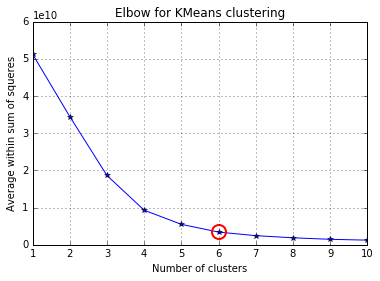

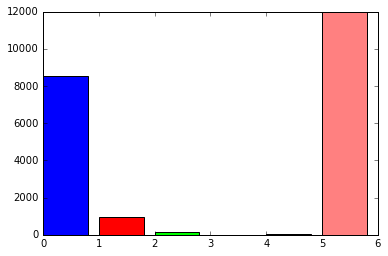

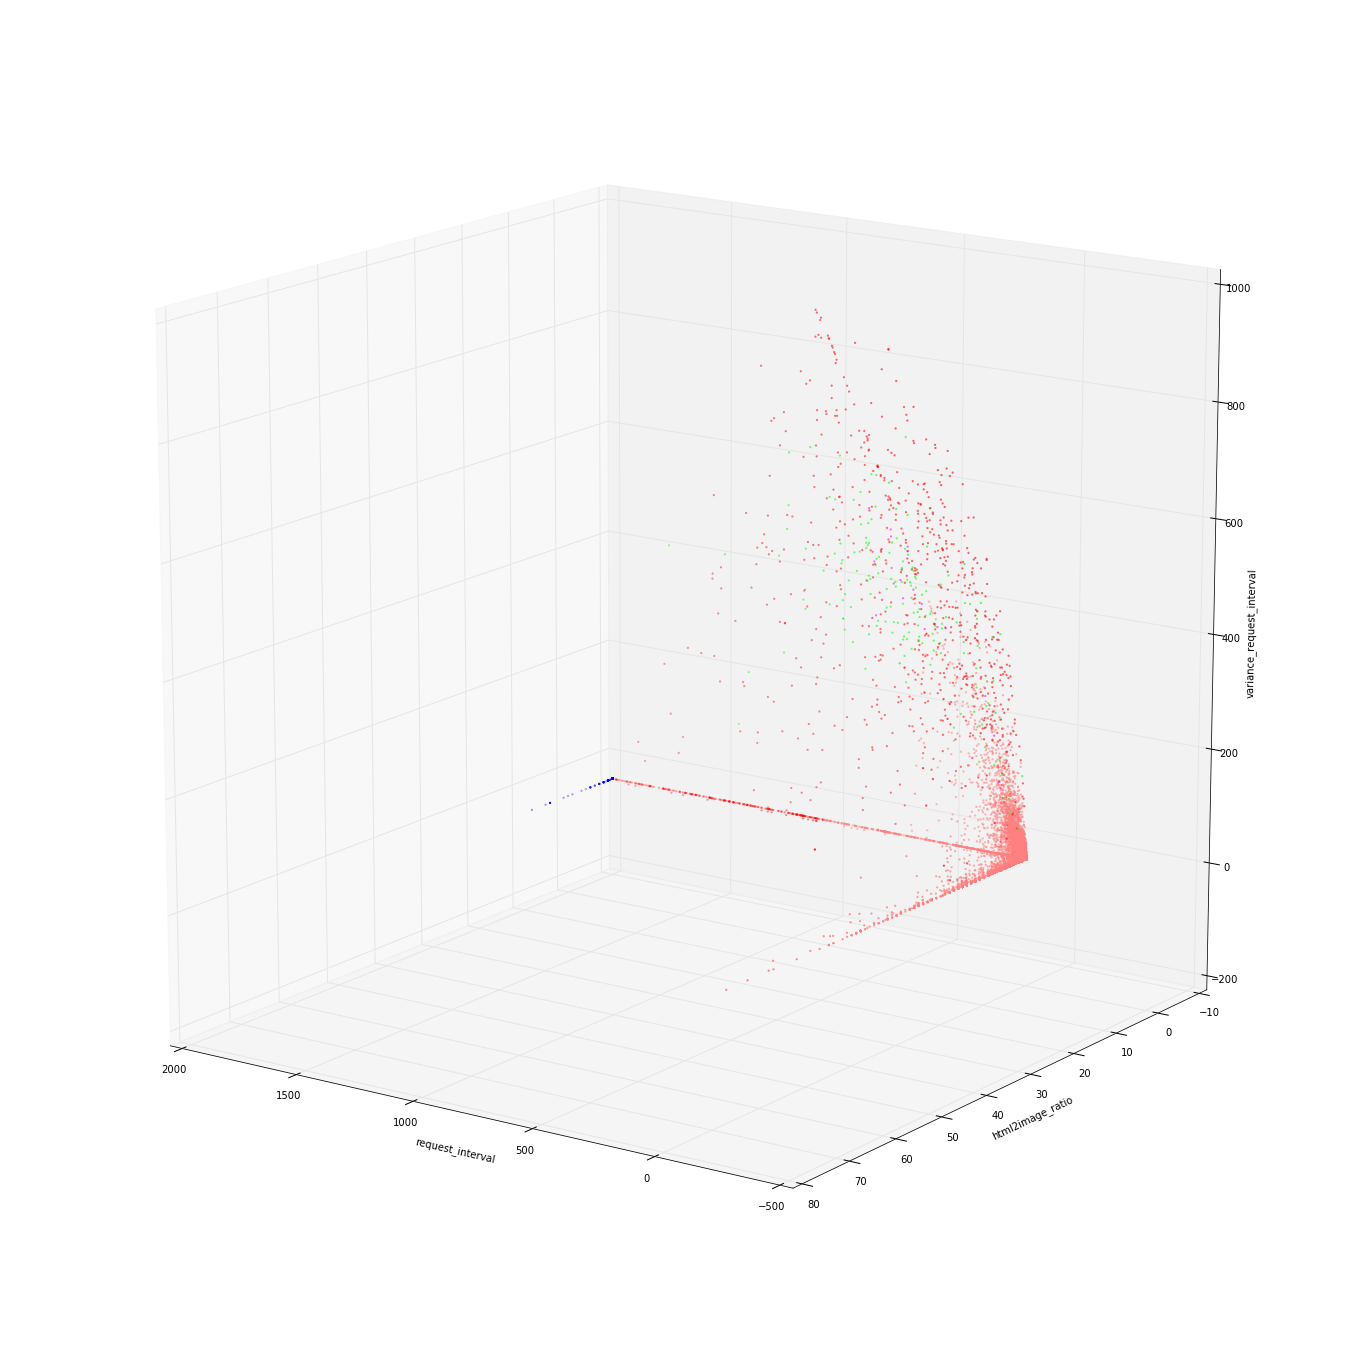

In [7]:
import sklearn
from sklearn.cluster import KMeans

def get_best_clustering_model(X, max_number_of_clusters):
    cost = []
    KK = range(1,max_number_of_clusters+1)
    kms = []
    # calculate all the clustering and cost
    for no_of_clusters in KK:
        km = KMeans(n_clusters=no_of_clusters, precompute_distances = True, max_iter = 500, n_init = 30)
        km.fit(X)
        kms.append(km)
        
        sizes = [0]*no_of_clusters
        for i in km.predict(X): 
            sizes[i] = sizes[i]+1
        print sizes

        #centroids = km.cluster_centers_ 
        #distances = cdist(X, centroids, 'euclidean')
        #cIdx = np.argmin(distances,axis=1) 
        #dist = np.min(distances,axis=1) 
        #tot_withinss = sum(dist**2)  # Total within-cluster sum of squares

        #cost.append(tot_withinss / X.shape[0]) 
        cost.append(km.inertia_)
    
    # calculate first derivative
    derivative1 = [cost[i+1]-cost[i] for i in range(len(cost)-1)]
    #print derivative1
        
    # calculate second derivative
    derivative2 = [derivative1[i+1]-derivative1[i] for i in range(len(derivative1)-1)]
    #print derivative2
    
    max2 = argrelextrema(np.argsort(derivative2), np.less) 
    num_clusters = 4 
    if(len(max2[0]) > 0):
        num_clusters = max2[0][0] + 3
    else:
        # calculate third derivative
        derivative3 = [derivative2[i+1]-derivative2[i] for i in range(len(derivative2)-1)]
        #print derivative3

        max3 = argrelextrema(np.argsort(derivative3), np.greater) 
        if(len(max3[0]) > 0):
            num_clusters = max3[0][0] + 4 
        
    return kms[num_clusters-1], cost

max_number_of_clusters = 10
model,cost = get_best_clustering_model(X, max_number_of_clusters)

labels = model.predict(X)

num_clusters = model.n_clusters
print "Num clusters:", num_clusters

%matplotlib inline
from matplotlib import pyplot as plt
from matplotlib import cm

KK = range(1,max_number_of_clusters+1)

# elbow curve
kIdx = num_clusters      
clr = cm.spectral( np.linspace(0,1,10) ).tolist()
mrk = 'os^p<dvh8>+x.'

fig = plt.figure()
ax = fig.add_subplot(111)
ax.plot(KK, cost, 'b*-')
ax.plot(num_clusters, cost[num_clusters-1], marker='o', markersize=14, 
    markeredgewidth=2, markeredgecolor='r', markerfacecolor='None')
#ax.set_ylim((0,100))
plt.grid(True)
plt.xlabel('Number of clusters')
#plt.ylabel('Percentage of variance explained (%)')
plt.ylabel('Average within sum of squeres')
plt.title('Elbow for KMeans clustering')

color_set = [
[0, 0, 255],      #Blue
[255, 0, 0],      #Red
[0, 255, 0],      #Green
[255, 255, 0],    #Yellow
[255, 0, 255],    #Magenta
[255, 128, 128],  #Pink
[128, 128, 128],  #Gray
[128, 0, 0],      #Brown
[255, 128, 0],    #Orange
]

def get_colors(N=5):
    result = []
    for x in range(N):
        s = color_set[x % len(color_set)]
        result.append([s[0]/255.0,s[1]/255.0,s[2]/255.0,1])
    return result

palette = get_colors(num_clusters+1)


#cluster histogramm
sizes = [0]*model.n_clusters

for i in model.predict(X): 
    sizes[i] = sizes[i]+1
print sizes
index_max = sizes.index(max(sizes))

cluster_sizes = float(sizes[index_max])/ X.shape[0] * 100

#print cluster_sizes
left = [] 
for i in range(len(sizes)):
    left.append(i)
    
fig = plt.figure()
ax = fig.add_subplot(111)
ax.bar(left,sizes, color = palette)


X_plot = X[labels >= 0,: ]
labels_plot = labels[labels >= 0]

colors = []
g = 0
for i in labels_plot:
    colors.append(palette[i])
    #colors.append(palette[g])
    #g = g + 1
    #if g == 8:
    #    g = 0
    
def plot3(indexes):
    fig = figure(figsize=(24,24))
    ax = fig.gca(projection='3d')
    #fig = plt.figure(figsize=(14,14))
    #ax = fig.add_subplot(111, projection='3d')

    ax.set_xlabel(features[indexes[0]])
    ax.set_ylabel(features[indexes[1]])
    ax.set_zlabel(features[indexes[2]])
    azim = 125
    elev = 15
    #ax.set_autoscale_on(False)
    #ax.axis([0.9, 1.5, -50, 50, 0, 400000])
    ax.view_init(elev, azim) 

    # plot points in 3D
    class1 = 0.6 * random.standard_normal((200,3))
    x = X_plot[:,indexes[0]]
    y = X_plot[:,indexes[1]]
    z = X_plot[:,indexes[2]]
    
    #x = random.random(len(colors))
    #y = random.random(len(colors))
    #z = random.random(len(colors))

    ax.scatter(x,y,z, s=5, edgecolors='none', c = colors, marker='o')

    #ax.set_xlim([0,10])
    #ax.set_ylim([0,1000000])
    #ax.set_zlim([0,30])
    
plot3([0,1,2])


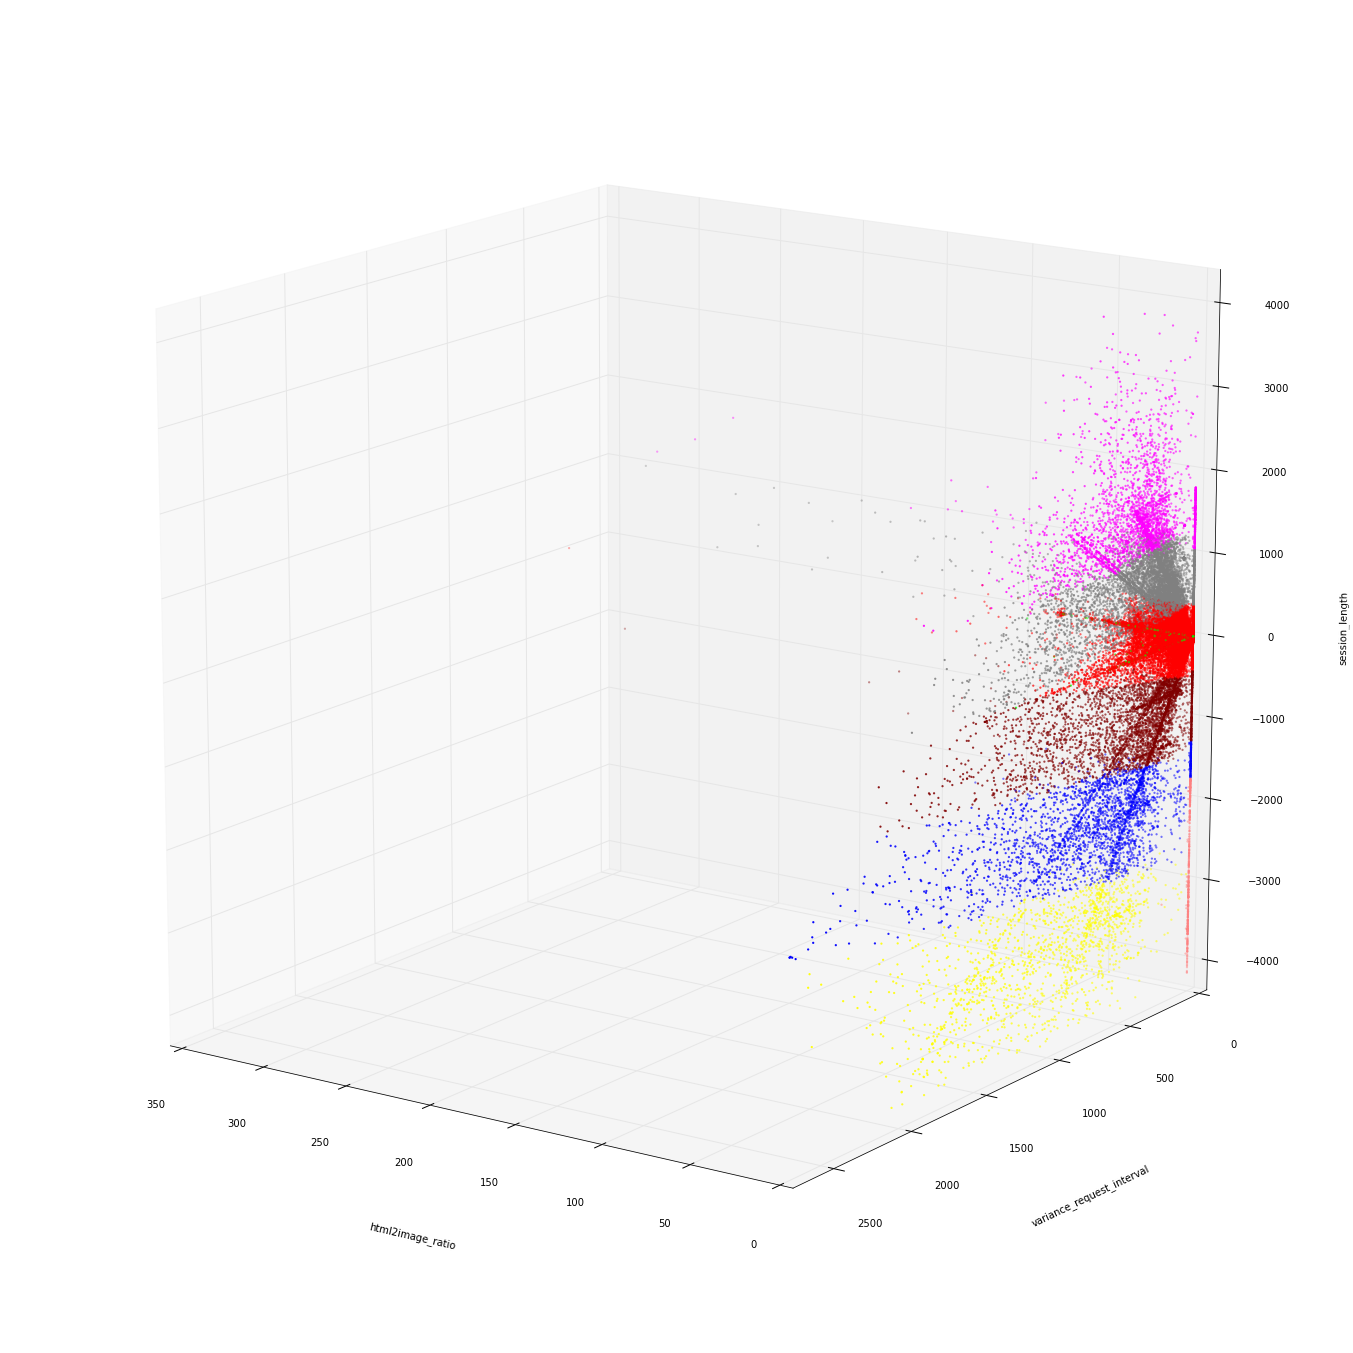

In [18]:
plot3([1,2,3])
#plot3([2,3,4])

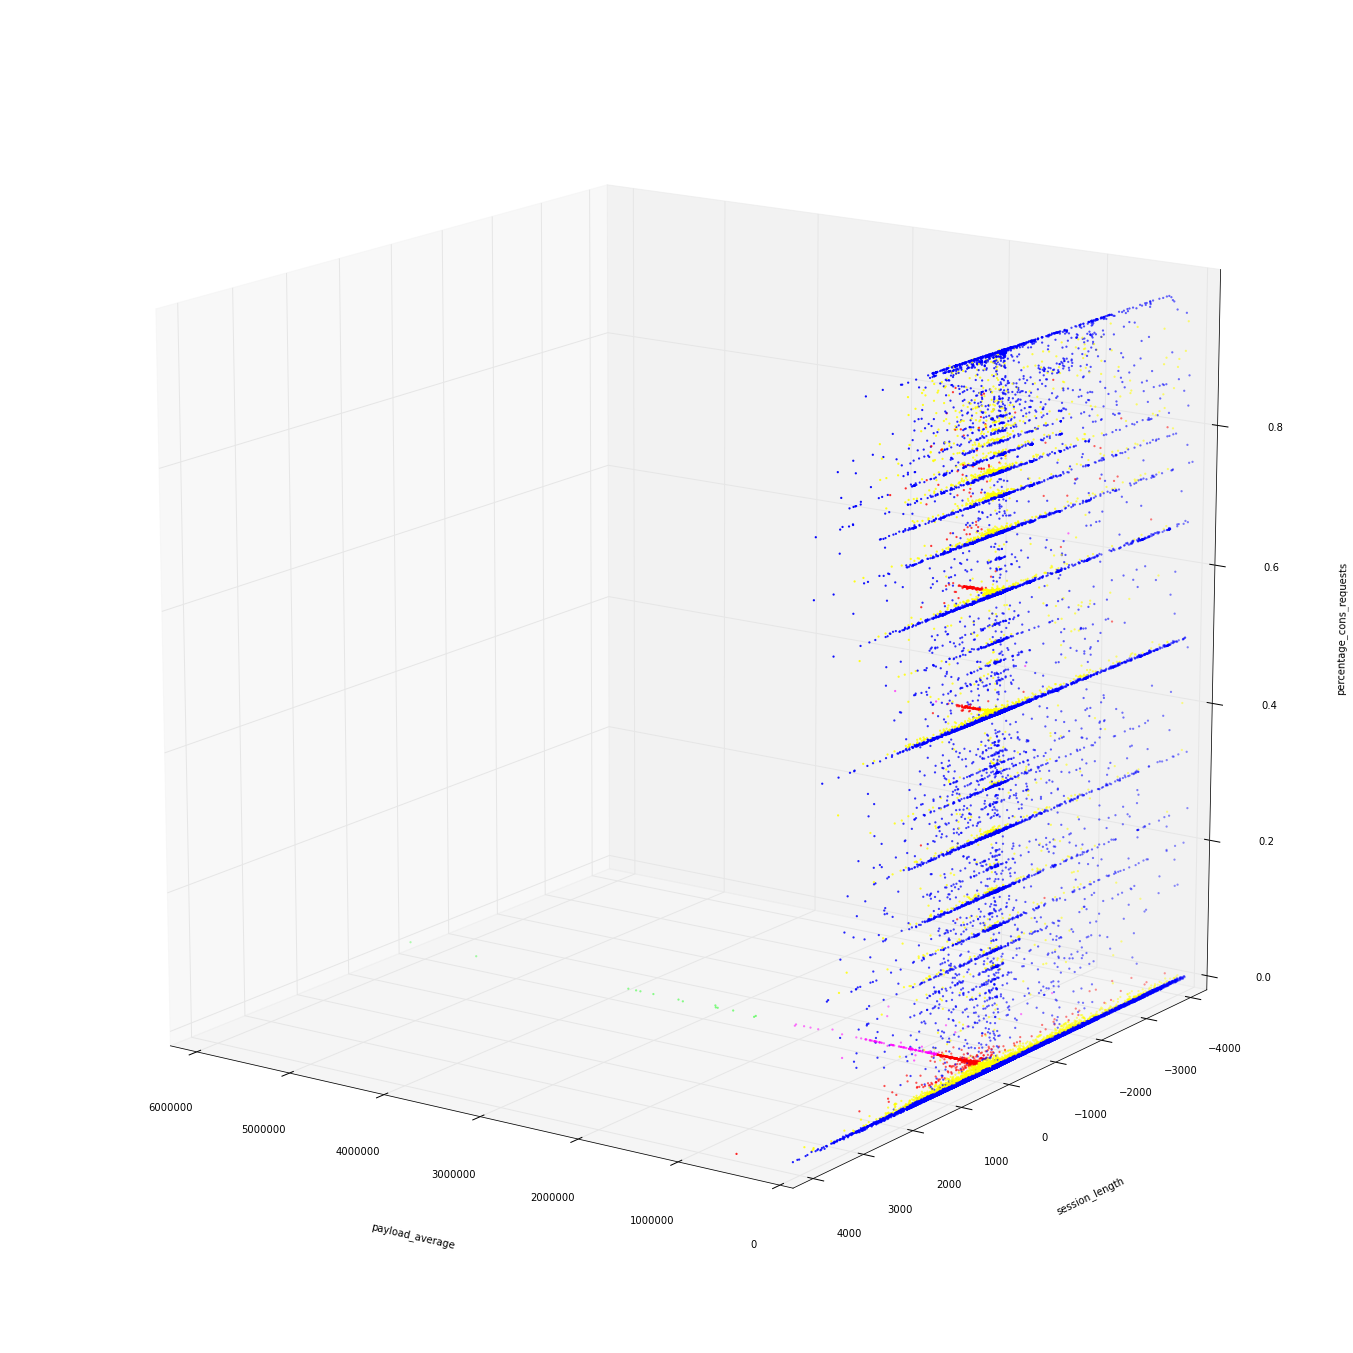

In [5]:
plot3([1,3,4])